
MIT Open Source License: <br>
Copyright (c) 2018 Daniel C. Elton 

<sub>Permission is hereby granted, free of charge, to any person obtaining a copy</sub>
<sub>of this software and associated documentation files (the "Software"), to deal</sub>
<sub>in the Software without restriction, including without limitation the rights</sub>
<sub>to use, copy, modify, merge, publish, distribute, sublicense, and/or sell</sub>
<sub>copies of the Software, and to permit persons to whom the Software is</sub>
<sub>furnished to do so, subject to the following conditions:</sub>

<sub>The above copyright notice and this permission notice shall be included in all</sub>
<sub>copies or substantial portions of the Software.</sub>

<sub>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR</sub>
<sub>IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,</sub>
<sub>FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE</sub>
<sub>AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER</sub>
<sub>LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,</sub>
<sub>OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE</sub>
<sub>SOFTWARE.</sub>

### Load all libraries, read in data

In [1]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
#from keras import regularizers
#from keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout
#from keras_tqdm import TQDMNotebookCallback
from sklearn import cross_validation
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso, LinearRegression, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, FastICA
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

def fp_Estate(mol):
    return FingerprintMol(mol)[0][6:38]

#Read the data
data = pd.read_excel('../datasets/Huang_Massa_data_with_all_SMILES.xlsx', skipfooter=1)

target_prop = 'Explosive energy (kj/cc)'

#Add some new columns
data['Mols'] = data['SMILES'].apply(Chem.MolFromSmiles)

#data['Fingerprint'] = data['Mols'].apply(lambda x:GetAvalonFP(x, nBits=500))
data['Fingerprint'] = data['Mols'].apply(fp_Estate)

XEstate = np.array(list(data['Fingerprint']))

#important - add hydrogens!!
data['Mols'] = data['Mols'].apply(Chem.AddHs)

num_mols = len(data)
y = data[target_prop].values
                                           


/home/dan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from mmltoolkit.featurizations import *

num_atoms = []
for mol in data['Mols']:
    mol = Chem.AddHs(mol)
    num_atoms += [mol.GetNumAtoms()]
    
max_atoms = int(max(num_atoms))

X_Cmat_as_vec = np.zeros((num_mols, (max_atoms**2-max_atoms)//2 + max_atoms))
X_Cmat_eigs = np.zeros((num_mols, max_atoms))
X_Cmat_unsorted_eigs = np.zeros((num_mols, max_atoms))

X_summedBoB = []
filename_list = []

for i, refcode in enumerate(data['Molecular Name']):
    filename = '../HM_all_xyz_files/'+refcode+'.xyz'
    this_Cmat_eigs, this_Cmat_as_vec = coulombmat_and_eigenvalues_as_vec(filename, max_atoms )
    this_Cmat_unsorted_eigs, this_Cmat_as_vec = coulombmat_and_eigenvalues_as_vec(filename, max_atoms, sort=False)

    summed_BoB_feature_names, summedBoB = summed_bag_of_bonds(filename)
    X_summedBoB += [summedBoB]

    filename_list += [filename]
    
    X_Cmat_eigs[i,:] = this_Cmat_eigs
    X_Cmat_unsorted_eigs[i,:] = this_Cmat_eigs
    X_Cmat_as_vec[i,:] = this_Cmat_as_vec

X_summedBoB = np.array(X_summedBoB)



In [3]:
bond_types, X_LBoB = literal_bag_of_bonds(list(data['Mols'])) 


In [6]:
X_AM_eigs = adjacency_matrix_eigenvalues(list(data['Mols']))
X_AM_eigs_BO = adjacency_matrix_eigenvalues(list(data['Mols']), useBO=True)
X_DM_eigs = distance_matrix_eigenvalues(list(data['Mols']))
X_CP_BO = characteristic_poly(list(data['Mols']), useBO=True)

In [7]:
BoB_feature_list, X_BoB = bag_of_bonds(filename_list, verbose=False)


# Oxygen balance descriptors

In [8]:
data.columns

Index(['num', 'Molecular Name', 'Formula', 'Density (g/cm3)',
       'Delta Hf solid (kj/mol)', 'Explosive energy (kj/cc)',
       'Shock velocity (km/s)', 'Particle velocity (km/s)',
       'Speed of sound (km/s)', 'Pressure (Gpa)', 'T(K)', 'TNT Equiv (per cc)',
       'group', 'SMILES', 'NOTE', 'Mols', 'Fingerprint'],
      dtype='object')

In [9]:
from  mmltoolkit.descriptors import * 

data['Oxygen Balance_1600'] = data['Mols'].apply(oxygen_balance_1600)
data['Oxygen Balance_100'] = data['Mols'].apply(oxygen_balance_100)
data['modified OB'] = data['Mols'].apply(modified_oxy_balance)
data['OB atom counts'] = data['Mols'].apply(return_atom_nums_modified_OB)
data['combined_nums'] =  data['Mols'].apply(return_combined_nums)


X_OB100 = np.array(list(data['Oxygen Balance_100'])).reshape(-1,1)     
X_OB1600 = np.array(list(data['Oxygen Balance_1600'])).reshape(-1,1)     
X_OBmod = np.array(list(data['modified OB'])).reshape(-1,1)   
X_OB_atom_counts = np.array(list(data['OB atom counts']))
X_combined = np.array(list(data['combined_nums']))

X_Estate_combined = np.concatenate((XEstate, X_combined), axis=1)
X_Estate_combined_Cmat_eigs = np.concatenate((X_Estate_combined, X_Cmat_eigs), axis=1)
X_Estate_combined_lit_BoB = np.concatenate((X_Estate_combined, X_LBoB), axis=1)
X_CustDesrip_lit_BoB = np.concatenate(( X_combined, X_LBoB), axis=1)


HOF = np.array(data['Delta Hf solid (kj/mol)'].values).reshape(-1,1)
densities =np.array(data['Density (g/cm3)'].values).reshape(-1,1)


X_s1 = np.concatenate(( X_LBoB, densities), axis=1)
X_s2 = np.concatenate(( X_LBoB, densities), axis=1)

st = StandardScaler()
X_s1 = st.fit_transform(X_s1)
X_s2 = st.fit_transform(X_s2)

                                           


# Experiments with dimensionality reduction / embedding techniques 

In [10]:
from sklearn.manifold import TSNE, SpectralEmbedding
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FastICA
from mmltoolkit.CV_tools import * 
import warnings
warnings.filterwarnings("ignore")

def test_dimensionality_reduction(X, y, n_test=20, verbosity=0, plot = True):
    
    if (verbosity == 2):
        verbose = True
    else:
        verbose = False
    
    ss = StandardScaler()
    
    num_features = X.shape[1]
    
    n_to_test = np.floor(np.linspace(2, 3*num_features//4, n_test))
 
    technique_abs_errors = {
                           "PCA" : np.zeros((len(n_to_test),1)), 
                           "PCA+ICA": np.zeros((len(n_to_test),1)), 
                           "t-SNE": np.zeros((len(n_to_test),1)), 
                           "spectral": np.zeros((len(n_to_test),1))
                         }

    for (i_n, ncomp) in enumerate(n_to_test):
        if (verbosity == 1): print("doing ", i_n, "of", len(n_to_test))
        X_PCA = PCA(n_components=ncomp).fit_transform(X)
        #X_PCA = ss.fit_transform(X_PCA)

        X_PCA_ICA  = FastICA().fit_transform(X_PCA)
        #X_PCA_ICA  = ss.fit_transform(X_PCA_ICA)

        if (ncomp < 4):
            X_tsne     = TSNE(n_components=ncomp, learning_rate=100).fit_transform(X)
        else:
            X_tsne     = TSNE(n_components=ncomp, method='exact', learning_rate=100).fit_transform(X)
            
        #X_tsne     = ss.fit_transform(X_tsne)
        
        X_spectral = SpectralEmbedding(n_components=ncomp).fit_transform(X)
        #X_spectral = ss.fit_transform(X_spectral)

        dim_reduction_dict = {
                               "PCA" : X_PCA, 
                               "PCA+ICA": X_PCA_ICA, 
                               "t-SNE": X_tsne, 
                               "spectral": X_spectral
                             }
               
        for technique in dim_reduction_dict.keys():
            scores_dict = tune_KR_and_test(dim_reduction_dict[technique], y, do_grid_search=True, verbose=verbose)
            technique_abs_errors[technique][i_n] = -1*scores_dict['test_abs_err'].mean()
            
    if (plot == True):
        scores_dict2 = tune_KR_and_test(X_Estate_combined_lit_BoB, y, cv=KFold(n_splits=5,shuffle=True), do_grid_search=True, verbose=False)
        score_base_KR = -1*scores_dict2['test_abs_err'].mean()
        
        plt.figure(figsize=(8,6))
        plt.clf()
        for technique in technique_abs_errors.keys():
            plt.plot(n_test, technique_abs_errors[technique], '-', label=technique)

        plt.plot([min(n_test),max(n_test)],[score_base_KR, score_base_KR],'--', label='none')
        plt.xlabel("num components", fontsize=19)
        plt.ylabel("MAE (kJ/cc)", fontsize=19)
        plt.legend(fontsize=15)
        plt.ylabel
        #plt.savefig('dimensionality_reduction_test_KR_EE.pdf')
        plt.show()
    
    return (n_to_test, technique_abs_errors)
                




In [11]:
scores_dict2 = tune_KR_and_test(X_Estate_combined_lit_BoB, y, cv=KFold(n_splits=5,shuffle=True), do_grid_search=True, verbose=False)
score_base_KR = -1*scores_dict2['test_abs_err'].mean()


TypeError: tuple indices must be integers or slices, not str

In [ ]:

plt.figure(figsize=(8,6))
plt.clf()
for technique in technique_abs_errors_scaled.keys():
    plt.plot(n_test, technique_abs_errors[technique], '-', label=technique)
    
plt.plot([min(n_test),max(n_test)],[score_base_KR, score_base_KR],'--', label='none')
plt.xlabel("num components", fontsize=19)
plt.ylabel("MAE (kJ/cc)", fontsize=19)
plt.legend(fontsize=15)
plt.ylabel
plt.savefig('dimensionality_reduction_test_KR_EE.pdf')
plt.show()



# Comparison of featurizations 

In [29]:
featurization_dict = {#"stacking density" : X_s1,
                      #"stacking density & HOF" : X_s2,
                    "truncated E-state": XEstate,
                 "Oxygen balance$_{100}$": X_OB100, 
                 "Oxygen balance$_{1600}$": X_OB1600, 
                 #"Oxygen balance atom counts": X_OB_atom_counts,
                 "custom descriptor set (CDS)": X_combined,
                 "sum over bonds (SoB)" : X_LBoB,
                 'E-state + custom descriptor set':   X_Estate_combined,
                 "Coulomb matrices as vec" :   X_Cmat_as_vec,
                 "Coulomb matrix eigenvalues": X_Cmat_eigs,
                 "Bag of Bonds (BoB)": X_BoB,
                 "Summed Bag of Bonds": X_summedBoB, 
                 "E-state + CDS + SoB":X_Estate_combined_lit_BoB,
                 "CDS + SoB": X_CustDesrip_lit_BoB,
                 "SoB + OB100": np.concatenate(( X_LBoB, X_OB100), axis=1)
                 #"Adjacency matrix eigenvalues": X_AM_eigs,
                 #"Adjacency matrix w/ bond order eigenvalues ": X_AM_eigs_BO,
                 # Characteristic polynomial of AM w BO": X_CP_BO,
                 # "Graph distance matrix eigenvalues": X_DM_eigs,
}

In [33]:
from mmltoolkit.featurization_comparison import *
import warnings
warnings.filterwarnings("ignore")

#targets = [ 'Density (g/cm3)', 'Delta Hf solid (kj/mol)', 'Explosive energy (kj/cc)', 'Shock velocity (km/s)', 
 #          'Particle velocity (km/s)', 'Speed of sound (km/s)', 'Pressure (Gpa)', 'T(K)', 'TNT Equiv (per cc)']

#units = ['g/cc', 'kJ/mol', 'kJ/cc', 'km/s', 'km/s', 'km/s', 'GPa', 'K', '']

#targets = ['Pressure (Gpa)']
#units = ['GPa']

targets = ['Explosive energy (kj/cc)']
units = ['kJ/cc']

for (i, target) in enumerate(targets):  
    y = data[target].values
    test_featurizations_and_plot(featurization_dict, y, target_prop_name=target,
                                 units=units[i], verbose=True, save_plot=False,
                                ) 

running truncated E-state
doing outer fold 1 of 20
best params:  {'alpha': 0.007934096665797492, 'coef0': 1, 'degree': 3, 'gamma': 0.0008685113737513556, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 2 of 20
best params:  {'alpha': 0.017426333860096472, 'coef0': 1, 'degree': 3, 'gamma': 0.001599858719606064, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 3 of 20
best params:  {'alpha': 0.011758495540521533, 'coef0': 1, 'degree': 3, 'gamma': 0.001599858719606064, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 4 of 20
best params:  {'alpha': 0.011758495540521533, 'coef0': 1, 'degree': 3, 'gamma': 0.001599858719606064, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 5 of 20
best params:  {'alpha': 0.003612342699709423, 'coef0': 1, 'degree': 3, 'gamma': 0.001599858719606064, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 6 of 20
best params:  {'alpha': 0.004397603609302712, 'coef0': 1, 'degree': 3, 'gamma': 0.001599858719606064, 'kernel': '

best params:  {'alpha': 1.0718913192051264e-07, 'coef0': 1, 'degree': 3, 'gamma': 1.9306977288832536e-06, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 11 of 20
best params:  {'alpha': 3.180625692794119e-12, 'coef0': 1, 'degree': 3, 'gamma': 1.67683293681101e-07, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 12 of 20
best params:  {'alpha': 0.014314589375234756, 'coef0': 1, 'degree': 3, 'gamma': 0.001599858719606064, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 13 of 20
best params:  {'alpha': 0.04659525668664668, 'coef0': 1, 'degree': 3, 'gamma': 7.543120063354639e-05, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 14 of 20
best params:  {'alpha': 3.2550885998350563e-15, 'coef0': 1, 'degree': 3, 'gamma': 5.963623316594661e-11, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 15 of 20
best params:  {'alpha': 0.15167168884709178, 'coef0': 1, 'degree': 3, 'gamma': 7.543120063354639e-05, 'kernel': 'rbf', 'kernel_params': None}
doing oute

best params:  {'alpha': 0.017426333860096472, 'coef0': 1, 'degree': 3, 'gamma': 0.0004714866363457409, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 20 of 20
best params:  {'alpha': 0.009658832241158669, 'coef0': 1, 'degree': 3, 'gamma': 0.001599858719606064, 'kernel': 'rbf', 'kernel_params': None}
running E-state + custom descriptor set
doing outer fold 1 of 20
best params:  {'alpha': 0.017426333860096472, 'coef0': 1, 'degree': 3, 'gamma': 0.0004714866363457409, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 2 of 20
best params:  {'alpha': 0.007934096665797492, 'coef0': 1, 'degree': 3, 'gamma': 0.00013894954943731417, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 3 of 20
best params:  {'alpha': 0.0005052631065335679, 'coef0': 1, 'degree': 3, 'gamma': 1.2067926406393314e-05, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 4 of 20
best params:  {'alpha': 0.005353566677410719, 'coef0': 1, 'degree': 3, 'gamma': 0.0008685113737513556, 'kernel': 'rbf

best params:  {'alpha': 0.00110975249641207, 'coef0': 1, 'degree': 3, 'gamma': 3.5564803062231357e-06, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 8 of 20
best params:  {'alpha': 0.004397603609302712, 'coef0': 1, 'degree': 3, 'gamma': 4.094915062380436e-05, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 9 of 20
best params:  {'alpha': 0.000748810385759, 'coef0': 1, 'degree': 3, 'gamma': 3.5564803062231357e-06, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 10 of 20
best params:  {'alpha': 0.0001889652339691204, 'coef0': 1, 'degree': 3, 'gamma': 1.0481131341546875e-06, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 11 of 20
best params:  {'alpha': 0.0001552225357427048, 'coef0': 1, 'degree': 3, 'gamma': 3.5564803062231357e-06, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 12 of 20
best params:  {'alpha': 0.0016446761779946627, 'coef0': 1, 'degree': 3, 'gamma': 6.551285568595522e-06, 'kernel': 'rbf', 'kernel_params': None}
doing outer

best params:  {'alpha': 3.217641750250736e-05, 'coef0': 1, 'degree': 3, 'gamma': 2.023589647725164e-10, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 16 of 20
best params:  {'alpha': 6.442363508721371e-10, 'coef0': 1, 'degree': 3, 'gamma': 1.7575106248547965e-11, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 17 of 20
best params:  {'alpha': 1.5885651294280528e-07, 'coef0': 1, 'degree': 3, 'gamma': 6.866488450043026e-10, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 18 of 20
best params:  {'alpha': 2.643081486974103e-05, 'coef0': 1, 'degree': 3, 'gamma': 7.906043210907702e-09, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 19 of 20
best params:  {'alpha': 4.768611697714455e-05, 'coef0': 1, 'degree': 3, 'gamma': 7.906043210907702e-09, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 20 of 20
best params:  {'alpha': 0.0020022003718155844, 'coef0': 1, 'degree': 3, 'gamma': 9.102981779915227e-08, 'kernel': 'rbf', 'kernel_params': None}
runn

best params:  {'alpha': 5.1114334834401654e-14, 'coef0': 1, 'degree': 3, 'gamma': 1e-15, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 5 of 20
best params:  {'alpha': 0.00041504047578504725, 'coef0': 1, 'degree': 3, 'gamma': 1.2067926406393314e-05, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 6 of 20
best params:  {'alpha': 7.57525025877192e-14, 'coef0': 1, 'degree': 3, 'gamma': 1.8420699693267163e-15, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 7 of 20
best params:  {'alpha': 0.0009115888299750799, 'coef0': 1, 'degree': 3, 'gamma': 4.094915062380436e-05, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 8 of 20
best params:  {'alpha': 0.0001552225357427048, 'coef0': 1, 'degree': 3, 'gamma': 1.2067926406393314e-05, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 9 of 20
best params:  {'alpha': 0.001350993521198025, 'coef0': 1, 'degree': 3, 'gamma': 4.094915062380436e-05, 'kernel': 'rbf', 'kernel_params': None}
doing outer fold 10 of 2

\begin{tabular}{c c c c c c c c c}
                   name          & MAE_{\ff{train}}   &  MAE_{\ff{test}}  & MAPE_{\ff{test}} & RMSE_{\ff{test}}  & R^2_{\ff{train}} &  R^2_{\ff{test}} &  r_{\ff{train}} & r_{\ff{test}}          \\  
\hline
       Coulomb matrices as vec &   -0.395 $\pm$ 0.00 & -0.672 $\pm$ 0.00 & -21.86 &    nan &   0.57 & -0.05 &  0.67 &  0.20  \\
        Oxygen balance$_{100}$ &   -0.444 $\pm$ 0.00 & -0.543 $\pm$ 0.00 & -17.46 &    nan &   0.59 &  0.44 &  0.62 &  0.57  \\
    Coulomb matrix eigenvalues &   -0.314 $\pm$ 0.00 & -0.536 $\pm$ 0.00 & -15.73 &    nan &   0.81 &  0.37 &  0.82 &  0.48  \\
           Summed Bag of Bonds &   -0.262 $\pm$ 0.00 & -0.493 $\pm$ 0.00 & -13.63 &    nan &   0.85 &  0.18 &  0.85 &  0.56  \\
       Oxygen balance$_{1600}$ &   -0.419 $\pm$ 0.00 & -0.489 $\pm$ 0.00 & -15.66 &    nan &   0.67 &  0.41 &  0.68 &  0.56  \\
            Bag of Bonds (BoB) &   -0.213 $\pm$ 0.00 & -0.467 $\pm$ 0.00 & -12.60 &    nan &   0.89 &  0.54 &  0.90 &  

# Experiments with feature importance ranking with random forrest 

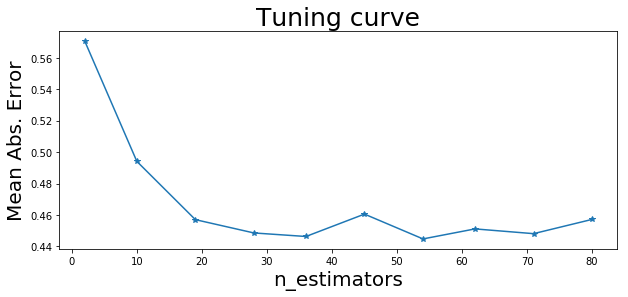

In [26]:
%matplotlib inline
from sklearn.model_selection import validation_curve, KFold
import matplotlib.pyplot as plt

num_to_try = np.linspace(2,80 , 10, dtype=int)
train_scores, valid_scores = validation_curve(RandomForestRegressor(), 
                                              X_LBoB, y, 
                                              "n_estimators",
                                               num_to_try, cv=KFold(n_splits=5,shuffle=True), n_jobs=4,
                                             scoring = 'neg_mean_absolute_error')

fig = plt.figure(figsize=(10,4))
plt.plot(num_to_try, -1*np.mean(valid_scores, axis=1),"-*")
plt.xlabel("n_estimators", fontsize=20)
plt.ylabel('Mean Abs. Error', fontsize=20)
plt.title('Tuning curve', fontsize=25)
plt.show()

In [27]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

rf = RandomForestRegressor(n_estimators=30)
rf = rf.fit(X_Estate_combined, y)

num_features = len(X_Estate_combined[0,:])

Estate_feature_names=[
"-CH3",
"=CH2",
"—CH2—",
"#CH",
"=CH-",
"aCHa",
">CH-",
"=c=",
"#C-",
"=C<",
"aCa",
"aaCa",
">C<",
"-NH3[+1]",
"-NH2",
"-NH2-[+1]",
"=NH",
"-NH-",
"aNHa",
"#N",
">NH-[+1]",
"=N—",
"aNa",
">N—",
"—N<<",
"aaNs",
">N<[+1]",
"-OH",
"=0",
"-0-",
"aOa",
"-F-"]

combined_descriptor_set_name = [
    "OB_100",
    "n_C",
    "n_N",
    "n_NO",
    "n_COH",
    "n_NOC",
    "n_CO",
    "n_H",
    "n_F",
    "n_N/n_C",
    "n_CNO2",
    "n_NNO2",
    "n_ONO",
    "n_ONO2",
    "n_CNN",
    "n_NNN",
    "n_CNO",
    "n_CNH2",
    "n_CN(O)C",
    "n_CF",
    "n_CNF"   
]



## shuffle method with RF

In [23]:
from collections import defaultdict
from sklearn.model_selection import ShuffleSplit
from mmltoolkit.CV_tools import mean_absolute_error

scores = defaultdict(list)
Y = y
X = X_LBoB

#crossvalidate the scores on a number of different random splits of the data
t=0
for train_idx, test_idx in ShuffleSplit(n_splits=10, test_size=.2).split(X):
    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = mean_absolute_error(Y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = mean_absolute_error(Y_test, rf.predict(X_t))
        scores[bond_types[i]].append((acc-shuff_acc)/acc)
    print(sorted([(round(np.mean(score), 3), feat) for
              feat, score in scores.items()], reverse=False))

ImportError: No module named 'mmltoolkit'

In [ ]:
from mmltoolkit.feature_importance import * 

sorted_feature_names, sorted_values = LASSO_feature_importance(X_LBoB, y, bond_types, print_latex=True)
sorted_feature_names, sorted_values = random_forest_feature_importance(X_LBoB, y, bond_types, print_latex=True)

In [4]:
from mmltoolkit.feature_importance import * 

sorted_feature_names, sorted_values = mean_decrease_accuracy(x, y, feature_names) 

ImportError: No module named 'mmltoolkit'